# Breadth-First Search with Repeated State Checking

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github//ericmanley/ai_map_environments/blob/fully-observable-street-sweeper/notebooks/repeated_state_checking.ipynb)

This notebook shows how to take the breadth-first-search implementation from the **implementing search lab** and improve it with repeated state checking.

If you are running on Colab or don't have the `mapbots` module installed, you need to run this:

In [ ]:
import sys

!{sys.executable} -m pip install --upgrade git+https://github.com/ericmanley/ai_map_environments.git@fully-observable-street-sweeper

## Review

Remember, you can create an instance of the Fully Observable Street Sweeper World like this:

Setting up the map. This may take a few minutes.


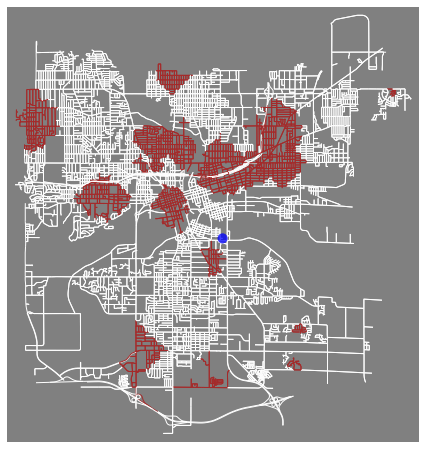

In [2]:
from mapbots import FullyObservableStreetSweeperWorld

planning_bot = FullyObservableStreetSweeperWorld(place="Des Moines, Iowa, USA",map_number=16)
planning_bot.display_map()

## Review: Finding the dirty regions

You can see a list of dirty regions like this:

In [3]:
dirty_regions = planning_bot.get_dirty_regions()
dirty_regions

[{'center': 160916159, 'size': 985},
 {'center': 160867904, 'size': 854},
 {'center': 160851954, 'size': 915},
 {'center': 160722789, 'size': 839},
 {'center': 161199203, 'size': 1457},
 {'center': 160862233, 'size': 488},
 {'center': 160979304, 'size': 456},
 {'center': 160728010, 'size': 608},
 {'center': 160870310, 'size': 1669},
 {'center': 160876198, 'size': 1366},
 {'center': 160820749, 'size': 1950},
 {'center': 5838882114, 'size': 1234},
 {'center': 160871935, 'size': 46},
 {'center': 160848975, 'size': 1959},
 {'center': 160963414, 'size': 520},
 {'center': 160742659, 'size': 1830},
 {'center': 160826171, 'size': 1655},
 {'center': 160963817, 'size': 1367},
 {'center': 160976123, 'size': 57},
 {'center': 160914945, 'size': 936},
 {'center': 160962293, 'size': 1284},
 {'center': 1164129727, 'size': 607},
 {'center': 160850808, 'size': 1603}]

Because this is a list of dictionaries, if you wanted to isolate one of those center location_ids, you could do it with an index and then selecting the `'center'` key like this.

In [4]:
destination = dirty_regions[0]['center']
print(destination)

160916159


## Review: Getting info about far away locations

Previously, we could only see the information about the current location and surrounding streets like this

In [5]:
planning_bot.get_current_location()

{'y': 41.5706865,
 'x': -93.5993636,
 'street_count': 1,
 'location_id': 160871916}

In [6]:
planning_bot.scan_next_streets()

[{'start': {'y': 41.5706865,
   'x': -93.5993636,
   'street_count': 1,
   'location_id': 160871916},
  'end': {'y': 41.570706,
   'x': -93.600617,
   'street_count': 3,
   'location_id': 160871915},
  'street_data': {'osmid': 16005567,
   'name': 'East Hillside Avenue',
   'highway': 'residential',
   'oneway': False,
   'reversed': True,
   'length': 104.292,
   'geometry': <LINESTRING (-93.599 41.571, -93.599 41.571, -93.6 41.571, -93.601 41.571)>,
   'speed_kph': 41.2,
   'travel_time': 9.1,
   'cleanliness': 'clean'}}]

But now you can get this information about any node - even one that is far away. Here's how you can do it about the `destination` note from above. 

We call the `get_location_info` method and pass the location_id of the far away node as an argument.

In [7]:
planning_bot.get_location_info( destination )

{'y': 41.5796593,
 'x': -93.6236171,
 'highway': 'traffic_signals',
 'street_count': 4,
 'location_id': 160916159}

We can also pass a location_id to `get_outgoing_streets_from_location` to see what streets you could access from that location if you were there. (note, there is also a `get_incoming_streets_from_location` method, but you may not need that)

In [8]:
planning_bot.get_outgoing_streets_from_location( destination )

[{'start': {'y': 41.5796593,
   'x': -93.6236171,
   'highway': 'traffic_signals',
   'street_count': 4,
   'location_id': 160916159},
  'end': {'y': 41.5798671,
   'x': -93.6223999,
   'street_count': 4,
   'location_id': 160912183},
  'street_data': {'osmid': 16018272,
   'lanes': '3',
   'name': 'Tuttle Street',
   'highway': 'tertiary',
   'oneway': False,
   'reversed': True,
   'length': 103.976,
   'geometry': <LINESTRING (-93.624 41.58, -93.623 41.58, -93.623 41.58, -93.623 41.58, -93...>,
   'speed_kph': 48.9,
   'travel_time': 7.7,
   'cleanliness': 'dirty'}},
 {'start': {'y': 41.5796593,
   'x': -93.6236171,
   'highway': 'traffic_signals',
   'street_count': 4,
   'location_id': 160916159},
  'end': {'y': 41.5809915,
   'x': -93.6240679,
   'street_count': 3,
   'location_id': 160916153},
  'street_data': {'osmid': 462365350,
   'name': 'Southwest 7th Street',
   'highway': 'secondary',
   'maxspeed': '35 mph',
   'oneway': False,
   'reversed': True,
   'length': 152.82,
 

## New Stuff: Adding support for repeated state checking

Here's a variation of the BFS implementation but with repeated state checking

The `SSWSearchNode` class is the same as before.

In [9]:
# We need a way to represent the nodes in the tree
# I'm trying to keep this one simple, but you could
# use better object-oriented programming practices
class SSWSearchNode:
    
    def __init__(self,location,parent=None):
        
        self.location = location #this is the state
        
        self.parent = parent #keeps track of the node that leads to this one
        self.children = [] #a list of all the nodes that appear below this when expanded
        
    # we'll add all the new nodes using this function when we "expand" this node    
    def add_child(self,new_child_node):
        self.children.append(new_child_node)   

This function is the same as before, but the three new lines of code are preceeded by `"""multiline comments"""`.

In [10]:
from collections import deque


def bfs_repeat_checking(bot,destination):
    # initialize the frontier using the initial state of problem
    initial_location = bot.get_current_location()
    root_node = SSWSearchNode(initial_location["location_id"])
    frontier = deque()
    frontier.append(root_node)
    """
    Here we create a set that will contain all of the location_id's for
    locations in nodes that we have expanded so far. The set data structure
    should allow for O(1) insertion and lookup
    """
    expanded_nodes = set() 
    while True:
        # if the frontier is empty then return failure
        if frontier == []:
            return None #failure
        
        # choose a leaf node from the frontier according to strategy
        chosen_leaf = frontier.popleft() #take the thing off the front of the "queue"
        """
        Since we are going to expand this node, let's add it to the expanded nodes set
        """
        expanded_nodes.add(chosen_leaf.location)
        
        # if the node contains a goal state then return the corresponding solution
        if chosen_leaf.location == destination: #destination is the goal
            # we're looping through the tree and creating a list from the locations in each node
            route = deque()
            curr_node = chosen_leaf
            while curr_node.parent != None:
                route.appendleft(curr_node.location)
                curr_node = curr_node.parent
            return route
        # else expand the node and add the resulting nodes to the frontier
        else:
            for street in bot.get_outgoing_streets_from_location( chosen_leaf.location ):
                """
                We only want to put new nodes in the tree if we haven't previous expanded one
                with the same location. The location we're considering is the one at the other
                end of the current street.
                """
                if street["end"]["location_id"] not in expanded_nodes:
                    new_node = SSWSearchNode(street["end"]["location_id"],parent=chosen_leaf)
                    chosen_leaf.add_child(new_node)
                    frontier.append(new_node)

We can display the locations along the route we calculated:

In [11]:
dest1 = dirty_regions[10]['center']
calculated_route = bfs_repeat_checking(planning_bot,dest1)
calculated_route

deque([160871915,
       160878811,
       160765394,
       160867891,
       160867894,
       160871925,
       160869289,
       542889453,
       160871924,
       160828133,
       542890431,
       160866459,
       160866466,
       160810147,
       160810155,
       160919521,
       160923676,
       3144322809,
       352905949,
       352905944,
       352905919,
       5928579315,
       5928579311,
       352905705,
       1114261297,
       1114261303,
       352905758,
       352905402,
       6597736442,
       160909063,
       160740234,
       160754006,
       1923819797,
       160760901,
       160789255,
       160731546,
       705209149,
       160814168,
       160991274,
       160986310,
       160795610,
       160795591,
       160950391,
       160925376,
       160966464,
       160868760,
       160868763,
       160938866,
       160938869,
       160831791,
       160802473,
       160831796,
       160831798,
       160831802,
       160831804,
   

But remember, this is just a plan - we haven't actually moved yet. Let's do it!

In [12]:
planning_bot.get_current_location()

{'y': 41.5706865,
 'x': -93.5993636,
 'street_count': 1,
 'location_id': 160871916}

In [13]:
for loc in calculated_route:
    planning_bot.move_to(loc)

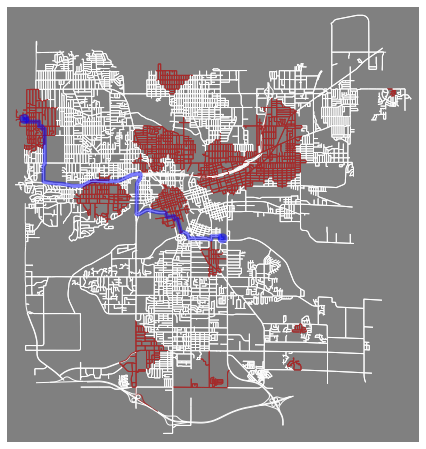

In [14]:
planning_bot.display_map()

# Assignment

For this assignment, you will implement another search algorithm (which can be handled similarly): A* Search.


Here are some hints on the things you'll need to do:
* You will need to decide what your path costs will be based on. The easiest option is probably to use the `"length"` value available within each `"street_data"` dictionary. Using `"travel_time"` would be better since the battery is depleted based on travel time.
* You will need to decide on a heuristic. You can use the `"x"` and `"y"` values within each location info dictionary to approximate the straight-line-distance with the Euclidean distance formula (below is some example code for two locations `loc_a` and `loc_b` but it should work with any two). If you are using travel time, you will need to multiply this by something to determine how many seconds you think it should take to follow the straight-line in an admissible way.

In [15]:
loc_a = planning_bot.get_current_location()
loc_a

{'y': 41.617745, 'x': -93.7037689, 'street_count': 3, 'location_id': 160820749}

In [16]:
dest4 = dirty_regions[4]['center']
loc_b = planning_bot.get_location_info( dest4 )
loc_b

{'y': 41.502339, 'x': -93.6334869, 'street_count': 3, 'location_id': 161199203}

In [17]:
import math
straight_line_distance = math.sqrt((loc_a["x"]-loc_b["x"])**2+(loc_a["y"]-loc_b["y"])**2)
straight_line_distance

0.1351225531138339

* You will need to add a way to keep track of the path cost to each node. For example, you could add a `self.path_cost` attribute to the `SSWSearchNode` class.
* You will need to have a way to calculate (path cost + heuristic) for any given node. I suggest adding a function like `"def path_cost_plus_heuristic(self, dest)"` to your `SSWSearchNode` class.
* Instead of using a queue to keep track of the frontier, you will need to have something that removes the item with the lowest (path cost + heuristic). An efficient way to do this is using the `heapq` class (https://docs.python.org/3/library/heapq.html ), but feel free to just write code that loops through the frontier and keeps track of the node with the lowest (path cost + heuristic) value.

## What to turn in

Create a new notebook with both the BFS code and your A* code. Run both on two copies of the same map, and then display the routes to see the different routes that were found (they may be similar depending on the map and locations). Make sure the displayed maps are visible in the notebook you submit. 

Also, include a text/Markdown cell in which you 

1. say what your path costs are based on
2. say what heuristic you used
3. give a short description of the changes you made to the code
4. describe any differences you noticed - in the routes that were calculated, in the time it took, etc.

Share the notebook in the same way you did for Project 1.

## Grading

The assignment will be worth 8 points.

* You can get up to 1 point if you turn in this starter notebook and you ran all the code yourself. Create a text/Markdown cell at the top where you explain that's what you did.
* You can get up to 4 points if you made some changes to the code that look like an attempt toward making A* work
* You can get up to 6 points if you attempted a non-working A* implementation and you describe what the problems are and your best guess about how they could probably be fixed
* You can get up to 7 points if you have a working implementation of A* and you display the map with your calculated route
* You can get up to 8 points if you have a working implementation of A*, you compare the routes with the BFS implementation in this notebook, and you address each of the items requested above in a text/Markdown cell.


## Extra Credit

* You can get up to 1 points of *extra credit* (which would essentially erase a missed small assignment) if you create a new Fully Observable Street Sweeper World agent that uses your A* function, and you can show that it is an improvement over your partially observable Street Sweeper World agent from Project 1. For this, I suggest giving both bots a larger starting battery life so you can see it cover more of the map. You can do that like this:

In [18]:
planning_bot = FullyObservableStreetSweeperWorld(place="Des Moines, Iowa, USA",map_number=16,initial_battery_life=1000000)

Setting up the map. This may take a few minutes.
